<a href="https://colab.research.google.com/github/marcv12/startup_success_prediction/blob/master/crunchbase_cleanup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from zipfile import ZipFile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize
import re



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn import preprocessing

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

from IPython.display import Image
!pip install pydotplus
import pydotplus
import graphviz
from six import StringIO

import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO

from pydot import graph_from_dot_data
from sklearn.utils import resample



from sklearn.tree import export_graphviz
import pydot
import random

! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/organizations.csv", encoding='utf-8')
degrees = pd.read_csv("/content/drive/My Drive/degrees.csv", encoding='utf-8')
funding_rounds = pd.read_csv("/content/drive/My Drive/funding_rounds.csv", encoding='utf-8')
people = pd.read_csv("/content/drive/My Drive/people.csv", encoding='utf-8')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.columns

Index(['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at',
       'updated_at', 'legal_name', 'roles', 'domain', 'homepage_url',
       'country_code', 'state_code', 'region', 'city', 'address',
       'postal_code', 'status', 'short_description', 'category_list',
       'category_groups_list', 'num_funding_rounds', 'total_funding_usd',
       'total_funding', 'total_funding_currency_code', 'founded_on',
       'last_funding_on', 'closed_on', 'employee_count', 'email', 'phone',
       'facebook_url', 'linkedin_url', 'twitter_url', 'logo_url', 'alias1',
       'alias2', 'alias3', 'primary_role', 'num_exits'],
      dtype='object')

In [ ]:
#turning all date columns in to date
df['founded_on'] =  pd.to_datetime(df['founded_on'], format='%Y-%m-%d', errors = 'coerce') # conveting column into date and ignoring errors
df['last_funding_on'] =  pd.to_datetime(df['last_funding_on'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['founded_on'] =  pd.to_datetime(df['founded_on'], format='%Y', errors = 'coerce') # conveting column into date and ignoring errors

In [ ]:
df = df.dropna(subset=['founded_on'])

In [ ]:
import datetime as dt
# Set cutoff date to 10 years from Jan 2022
cutoff_date = dt.datetime(2022, 1, 1) - pd.offsets.DateOffset(years=9)

# Filter DataFrame using boolean indexing
df = df[df['founded_on'] >= cutoff_date]

In [ ]:
#Select the columns that are of interest to us
df = df[['uuid', 'primary_role', 'country_code', 'region', 'status', 'category_list',
         'category_groups_list', 'num_funding_rounds', 'num_exits',
         'total_funding_usd', 'founded_on', 'last_funding_on',
         'linkedin_url', 'facebook_url', 'twitter_url', 'employee_count',
         ]]

In [ ]:
df.shape

(657005, 16)

In [ ]:
categorical = list(filter(lambda x: df[x].dtype=='object',df.columns))

def show_stats(dataframe, columns):
    stat = {}
    for col in columns:
        stat[col] =  [dataframe[col].nunique(), dataframe[col].isna().mean()*100, dataframe[col].dtype]
    return pd.DataFrame.from_dict(stat, orient='index', columns=['Unique',  'Missing values in %', 'DType'])
show_stats(df, categorical)

,Unique,Missing values in %,DType
uuid,657005,0.000000,object
primary_role,3,0.000000,object
country_code,210,11.629287,object
region,1916,11.629287,object
status,4,0.000000,object
category_list,257951,6.736022,object
category_groups_list,51055,6.736022,object
linkedin_url,458370,29.984703,object
facebook_url,393307,39.911568,object
twitter_url,325786,50.195661,object


In [ ]:
# Keep only uuids in `df`
uuids = df['uuid'].tolist()
people = people[people['featured_job_organization_uuid'].isin(uuids)]
funding_rounds = funding_rounds[funding_rounds['org_uuid'].isin(uuids)]
# jobs = jobs[jobs['org_uuid'].isin(uuids)]

In [ ]:
people.featured_job_organization_uuid.nunique()

192295

In [ ]:
people = people[['uuid', 'gender', 'featured_job_organization_uuid', 'featured_job_title']]
people

,uuid,gender,featured_job_organization_uuid,featured_job_title
8,d3ae96f0-4442-720f-1ec2-fc28eac94e53,male,a08dd843-1fd4-458c-89c5-d09576679836,Founder and Managing Partner
21,b0e4e511-a1f1-162d-005a-006a94ee35f6,male,904a716a-93d3-4456-9543-70fcf381e268,Co-Founder & Partner
22,b9ef118c-9258-b287-3107-59c6f3625134,male,516031a1-becf-71e6-0605-3a0b66669ccb,CEO
23,1a9f5046-024a-4656-d5c9-7526c8665b61,male,da43494a-5084-4247-81d2-0aaf8ab6fc06,Managing Partner
31,66728421-e17b-2f25-b41c-8c0be6f2ced3,male,5b6f80e2-59c2-0e8a-d03e-954c96f3e306,Co-founder and CEO
...,...,...,...,...
1663003,2dfce712-19f8-4bde-9abb-8462486a0ec0,male,15f2cd7c-370c-410e-991a-844649f0135e,Founder and CEO
1663005,f72f23e6-f9a6-413b-9ece-670b43e03ea2,male,f8efe8e0-c66c-44e2-833f-f3ff009d3312,Founder & Partner
1663021,4fca0c2a-1c79-4a19-8bda-b25d30916500,female,72e9d6fb-9931-44c8-9f92-16070d3decd2,"Co-Founder, Chief Executive Officer, and Presi..."
1663022,a3e7f3c5-ab3b-436c-9b19-dbe88de0609b,female,72e9d6fb-9931-44c8-9f92-16070d3decd2,"Chief Operating Officer, Co-Founder"


In [ ]:
num_senior = people.groupby('featured_job_organization_uuid')['uuid'].transform('count')
people['num_seniors'] = num_senior

In [ ]:
# Calculate the number of males in senior positions for each organization
male_data = people.loc[people['gender'] == 'male']
male_counts = male_data.groupby('featured_job_organization_uuid')['gender'].count()
male_counts = male_counts.reindex(people['featured_job_organization_uuid'].unique(), fill_value=0)

# Calculate the male ratio for each organization
people['male_senior_ratio'] = male_counts.loc[people['featured_job_organization_uuid']].values / people['num_seniors']
people['male_senior_ratio'] = people['male_senior_ratio'].fillna(0).round(2)  # Fill NaN with 0 and round to 2 decimal places

In [ ]:
people.groupby('featured_job_title')['uuid'].count().sort_values(ascending=False)

featured_job_title
Founder                                             22866
Co-Founder                                          22021
CEO                                                 18751
Founder & CEO                                       13070
Founder and CEO                                     10507
                                                    ...  
Content Marketing Lead & SEO Strategist                 1
Content Marketing Lead & Writer                         1
Content Marketing Manager, Author                       1
Content Marketing Senior Associate                      1
🥇Freelance Growth | Lead Generation | Automation        1
Name: uuid, Length: 63189, dtype: int64

In [ ]:
people['is_lead'] = people['featured_job_title'].apply(lambda x: ('founder' in str(x).lower() or 'co-founder' in str(x).lower()) or 'ceo' in str(x).lower() or 'Chairman' in str(x).lower() or 'Chief Executive Officer' in str(x).lower())

In [ ]:
people.loc[people.is_lead == True]

,uuid,gender,featured_job_organization_uuid,featured_job_title,num_seniors,male_senior_ratio,is_lead
8,d3ae96f0-4442-720f-1ec2-fc28eac94e53,male,a08dd843-1fd4-458c-89c5-d09576679836,Founder and Managing Partner,3,1.00,True
21,b0e4e511-a1f1-162d-005a-006a94ee35f6,male,904a716a-93d3-4456-9543-70fcf381e268,Co-Founder & Partner,29,0.59,True
22,b9ef118c-9258-b287-3107-59c6f3625134,male,516031a1-becf-71e6-0605-3a0b66669ccb,CEO,5,0.40,True
31,66728421-e17b-2f25-b41c-8c0be6f2ced3,male,5b6f80e2-59c2-0e8a-d03e-954c96f3e306,Co-founder and CEO,1,1.00,True
53,74f1fa36-db52-71fe-c693-6212d48c5df7,female,c8e38c2b-4c58-4794-9e8c-49bcc15b1c9c,CEO,3,0.67,True
...,...,...,...,...,...,...,...
1662968,f8d780d3-84dd-421c-92c5-a4bf6f595f0b,NaN,33ab3206-df42-43ad-8740-cc67aa4105b6,Founder,1,0.00,True
1663003,2dfce712-19f8-4bde-9abb-8462486a0ec0,male,15f2cd7c-370c-410e-991a-844649f0135e,Founder and CEO,1,1.00,True
1663005,f72f23e6-f9a6-413b-9ece-670b43e03ea2,male,f8efe8e0-c66c-44e2-833f-f3ff009d3312,Founder & Partner,1,1.00,True
1663021,4fca0c2a-1c79-4a19-8bda-b25d30916500,female,72e9d6fb-9931-44c8-9f92-16070d3decd2,"Co-Founder, Chief Executive Officer, and Presi...",2,0.00,True


In [ ]:
people = people.loc[people['is_lead'], :]

In [ ]:
people = people.groupby('featured_job_organization_uuid').first().reset_index()

In [ ]:
people.groupby('featured_job_organization_uuid')['uuid'].count().mean()

1.0

In [ ]:
people.featured_job_organization_uuid.nunique()

155633

Let's keep people in the degrees dataframe that are present in the people dataframe

In [ ]:
people_uuids = people['uuid'].tolist()
degrees = degrees[degrees['person_uuid'].isin(people_uuids)]

In [ ]:
# change the name of the 'uuid' column to 'people_uuid' to avoid any confusion
people = people.rename(columns={'uuid': 'people_uuid'})

In [ ]:
categorical_degrees = list(filter(lambda x: degrees[x].dtype=='object',degrees.columns))
show_stats(degrees, categorical_degrees)

,Unique,Missing values in %,DType
uuid,105908,0.000000,object
person_uuid,72886,0.000000,object
degree_type,11934,6.627450,object
completed_on,2358,29.189485,object


In [ ]:
# Convert completed_on column to datetime
degrees['completed_on'] = pd.to_datetime(degrees['completed_on'], errors='coerce')

In [ ]:
degrees['degree_type'].nunique()

11934

There are so many types of degrees. A more reasonable approach would be to count how many degrees each person has. In my opinion, this would be a good reflection of how educated a person is. We are considering number of degrees, whether completed or not because some knowledge can be taken out of a degree even if not completed

In [ ]:
# use groupby and transform to count the number of degrees per person
degrees['num_degrees'] = degrees.groupby('person_uuid')['uuid'].transform('count')

# drop duplicates and unnecessary columns
degrees = degrees.drop_duplicates(subset='person_uuid', keep='first')

In [ ]:
degrees = degrees.drop(['degree_type', 'completed_on', 'is_completed'], axis=1)

In [ ]:
# change the name of the 'age' column to 'years'
degrees = degrees.rename(columns={'uuid': 'degree_uuid'})

In [ ]:
degrees.sort_values('num_degrees', ascending=False)

,degree_uuid,person_uuid,num_degrees
162171,224ca2c7-1ebe-be44-f69c-ec41591a3f8a,3cb36ae4-b26e-e82d-5ce2-b57b5ef5cb26,14
574161,86b7a546-ddf7-48fc-8a5b-779e9593abaa,4aafc4d0-36e5-459e-b7bf-9b2cd37da491,10
535553,fd9bc495-566a-4b15-b4bc-31c33805ec8b,d525521a-d119-412b-af0f-7f85d5bccf2a,9
577496,9e51e729-f372-45e9-9f88-6df4ddd1046a,7723e506-8364-18ae-36f3-d915dab7ecb1,9
199529,7120c4e3-e4fe-b7b4-742c-ce2e742d9057,621052e7-d596-42e5-4571-d393ec611d96,9
...,...,...,...
323608,48a409b2-4b1d-4ff3-902e-951e68cd54ad,720fa089-06fb-4b4e-bbc0-9691c987b9e0,1
323616,57592c98-3848-4ab7-a677-5c596827dae7,f8f20124-6841-4dce-878f-e177cc4106b0,1
323626,e38075a0-d0ae-4c8a-acbf-8b7ffafe190b,d381e251-cd12-433c-9e15-8e0e552d9347,1
323627,0cac70db-b0f1-4361-bc65-75cfebe70c5f,5ced44d9-bd2e-4fa7-8782-59f2e4493478,1


There are still the people who have no degrees that we will account for later when merging

In [ ]:
cache_df = pd.merge(people, degrees, left_on='people_uuid', right_on='person_uuid', how = 'left' )

In [ ]:
cache_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155633 entries, 0 to 155632
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   featured_job_organization_uuid  155633 non-null  object 
 1   people_uuid                     155633 non-null  object 
 2   gender                          153535 non-null  object 
 3   featured_job_title              155633 non-null  object 
 4   num_seniors                     155633 non-null  int64  
 5   male_senior_ratio               155633 non-null  float64
 6   is_lead                         155633 non-null  bool   
 7   degree_uuid                     72886 non-null   object 
 8   person_uuid                     72886 non-null   object 
 9   num_degrees                     72886 non-null   float64
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 12.0+ MB


In [ ]:
cache_df = cache_df.drop(['degree_uuid', 'person_uuid'], axis=1)

#Fill na with 0 because these people have not completed any degree
cache_df['num_degrees'] = cache_df['num_degrees'].fillna(0)

In [ ]:
cache_df = pd.merge(df, cache_df, left_on='uuid', right_on='featured_job_organization_uuid', how = 'inner' )

In [ ]:
# group the funding_rounds dataframe by org_uuid and apply aggregation functions
grouped = funding_rounds.groupby('org_uuid').agg(
    seed=('investment_type', lambda x: int('seed' in x.values)),
    early_investment=('investment_type', lambda x: int(any([val in ['pre_seed', 'grant', 'angel'] for val in x]))),
    any_investment_funding =('investment_type', lambda x: int(any([val in ['series_a', 'series_b', 'series_c', 'series_d',
                                                                'series_e', 'series_f','series_h', 'series_i', 'series_j',
                                                                'series_unknown'] for val in x]))),
    debt_or_other=('investment_type', lambda x: int(any([val in ['debt_financing', 'convertible_note', 'post_ipo_debt', 'private_equity', 'non_equity_assistance', 'undisclosed'] for val in x]))),
    investor_count=('investor_count', 'sum'),
    total_raised=('raised_amount_usd', 'sum')
)

# reset the index to make org_uuid a column
new_df = grouped.reset_index()


In [ ]:
funding_rounds = new_df

In [ ]:
# funding_rounds = new_df.loc[new_df.total_raised != 0]

In [ ]:
cache_df = pd.merge(cache_df, funding_rounds, left_on='uuid', right_on='org_uuid', how = 'inner' )

In [ ]:
categorical_cache_df = list(filter(lambda x: cache_df[x].dtype=='object',cache_df.columns))
show_stats(cache_df, categorical_cache_df)

,Unique,Missing values in %,DType
uuid,78096,0.000000,object
primary_role,3,0.000000,object
country_code,158,0.741395,object
region,1112,0.741395,object
status,4,0.000000,object
category_list,51516,2.201137,object
category_groups_list,17417,2.201137,object
linkedin_url,64018,17.998361,object
facebook_url,48816,37.466708,object
twitter_url,50010,35.941662,object


In [ ]:
df_cols_cat = list(filter(lambda x: df[x].dtype=='object', df.columns))
show_stats(df, df_cols_cat)

,Unique,Missing values in %,DType
uuid,657005,0.000000,object
primary_role,3,0.000000,object
country_code,210,11.629287,object
region,1916,11.629287,object
status,4,0.000000,object
category_list,257951,6.736022,object
category_groups_list,51055,6.736022,object
linkedin_url,458370,29.984703,object
facebook_url,393307,39.911568,object
twitter_url,325786,50.195661,object


In [ ]:
cache_df.groupby('employee_count')['uuid'].count()

employee_count
1-10          35273
10000+           57
1001-5000       391
101-250        4214
11-50         29372
251-500        1361
5001-10000       54
501-1000        624
51-100         5218
unknown        1532
Name: uuid, dtype: int64

In [ ]:
# Define a dictionary that maps each label to a numerical value
label_dict = {'10000+': 9, '5001-10000': 8, '1001-5000': 7, '501-1000': 6, '251-500': 5, '101-250': 4, '51-100': 3, '11-50': 2, '1-10': 1, 'unknown': 0}

# Use the replace() method to assign numerical values to the labels
cache_df['employee_count_cat'] = cache_df['employee_count'].replace(label_dict)

In [ ]:
cache_df = cache_df.loc[cache_df.primary_role == 'company']

In [ ]:
cache_df.groupby('category_groups_list')['uuid'].nunique().sum()

75289

We notice that some companies belong to many category groups, let's keep only the main one.

In [ ]:
cache_df['category_groups_list'] = cache_df['category_groups_list'].str.split(',', expand=True)[0]

In [ ]:
cache_df = cache_df.drop(['primary_role', 'category_list', 'num_exits', 'featured_job_organization_uuid', 'people_uuid', 'org_uuid', 'total_raised', 'is_lead'], axis=1)

In [ ]:
cache_df = cache_df.drop('gender', axis=1)

In [ ]:
cache_df['social_media_presence'] = ((cache_df['linkedin_url'].notnull()) &
                                     (cache_df['twitter_url'].notnull()) &
                                     (cache_df['facebook_url'].notnull())).astype(int)

In [ ]:
cache_df = cache_df.drop(['twitter_url', 'facebook_url', 'linkedin_url', 'employee_count'], axis=1)

In [ ]:
cache_df = cache_df.loc[cache_df['status'] != 'ipo']

In [ ]:
cache_df['status'].value_counts()

operating    66693
closed        5485
acquired      3959
Name: status, dtype: int64

In [ ]:
cache_df.loc[cache_df['status'].isin(['closed', 'acquired']), 'status'] = 'exited'

In [ ]:
cache_df['status'].value_counts()

operating    66693
exited        9444
Name: status, dtype: int64

In [ ]:
df = cache_df.copy()

In [ ]:
(df.isin([0]).sum()/df.count()) *100 # some of the columns have a lot of zeros. Calculating zeros as apercentage of the total rows for each column

uuid                       0.000000
country_code               0.000000
region                     0.000000
status                     0.000000
category_groups_list       0.000000
num_funding_rounds         0.000000
total_funding_usd         18.429936
founded_on                 0.000000
last_funding_on            0.000000
featured_job_title         0.000000
num_seniors                0.000000
male_senior_ratio          9.343683
num_degrees               55.434283
seed                      39.920144
early_investment          62.530701
any_investment_funding    64.490327
debt_or_other             80.923861
investor_count            18.934290
employee_count_cat         1.945178
social_media_presence     54.039429
dtype: float64

In [ ]:
#Let's explore the target variable
df['status'].unique() #unique values in status column
#status column have three different values, this is what we are going to use to predict against

array(['operating', 'exited'], dtype=object)

In [ ]:
df.groupby("status")["uuid"].nunique()

status
exited        9444
operating    66693
Name: uuid, dtype: int64

In [ ]:
df['country_code'].unique() # no. of unique country code
#115 country code unique

array(['SWE', 'USA', 'GBR', 'IND', 'ARG', 'SGP', 'VNM', 'AUS', 'ARE',
       'BGR', 'FRA', 'CAN', 'IDN', 'DEU', 'NLD', 'BEL', 'PAK', 'JPN',
       'ISR', 'BRA', 'ITA', 'CHE', 'CHL', 'HKG', 'GRC', 'CZE', 'COL',
       'AUT', 'ESP', 'LUX', nan, 'POL', 'HRV', 'IRL', 'DNK', 'FIN', 'MEX',
       'HUN', 'TUR', 'RUS', 'NOR', 'LTU', 'KEN', 'JOR', 'KOR', 'UKR',
       'PHL', 'CHN', 'EGY', 'ISL', 'GHA', 'UGA', 'ZMB', 'ZAF', 'SRB',
       'THA', 'VEN', 'EST', 'MAC', 'ROM', 'MLT', 'PRT', 'BGD', 'PAN',
       'SVK', 'LVA', 'RWA', 'BMU', 'MKD', 'NGA', 'NZL', 'MAR', 'PER',
       'MYS', 'CIV', 'TWN', 'SVN', 'PSE', 'GTM', 'TUN', 'CMR', 'SAU',
       'BIH', 'PRI', 'ALB', 'JAM', 'CRI', 'TAN', 'NIC', 'MDA', 'CYP',
       'QAT', 'LBN', 'IMN', 'MMR', 'CYM', 'SYC', 'TTO', 'KWT', 'AZE',
       'ARM', 'GEO', 'PRY', 'BRB', 'NPL', 'ECU', 'ZWE', 'BLZ', 'BWA',
       'MDG', 'IRN', 'DOM', 'COD', 'SEN', 'BLR', 'AGO', 'URY', 'JEY',
       'KAZ', 'BHR', 'MUS', 'KHM', 'GIB', 'MLI', 'MWI', 'LIE', 'LKA',
       'SLV', '

In [ ]:
df.isnull().sum() #sum of null values in each column
# dataset also has some null values. Some of the columns have a lot of null values eg. state code and founded years

uuid                         0
country_code               569
region                     569
status                       0
category_groups_list      1643
num_funding_rounds           0
total_funding_usd            0
founded_on                   0
last_funding_on              0
featured_job_title           0
num_seniors                  0
male_senior_ratio            0
num_degrees                  0
seed                         0
early_investment             0
any_investment_funding       0
debt_or_other                0
investor_count               0
employee_count_cat           0
social_media_presence        0
dtype: int64

Let us see if better only in USA

In [ ]:
df.groupby('status')['total_funding_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
exited,9444.0,1.792691e+07,1.957502e+08,0.0,25000.0,559804.0,4687107.75,1.511880e+10
operating,66693.0,1.749950e+07,1.082925e+08,0.0,81868.0,1050000.0,6140000.00,1.100012e+10


We see that exited and operating companies have very close means so from an average total funding POV, they are extremely close. In other words, on average they receive the same amount of funding. So the amount of money received doesn't seem to differentiate them.

In [ ]:
df.dtypes

uuid                              object
country_code                      object
region                            object
status                            object
category_groups_list              object
num_funding_rounds               float64
total_funding_usd                float64
founded_on                datetime64[ns]
last_funding_on           datetime64[ns]
featured_job_title                object
num_seniors                        int64
male_senior_ratio                float64
num_degrees                      float64
seed                               int64
early_investment                   int64
any_investment_funding             int64
debt_or_other                      int64
investor_count                   float64
employee_count_cat                 int64
social_media_presence              int64
dtype: object

Let's see

In [ ]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
df.groupby('status')[num_cols].mean().T

status,exited,operating
num_funding_rounds,2.168996e+00,2.422308e+00
total_funding_usd,1.792691e+07,1.749950e+07
num_seniors,2.417302e+00,2.327561e+00
male_senior_ratio,8.490841e-01,8.186727e-01
num_degrees,5.942397e-01,6.297063e-01
seed,6.489835e-01,5.939754e-01
early_investment,2.548708e-01,3.916603e-01
any_investment_funding,3.447692e-01,3.565592e-01
debt_or_other,1.899619e-01,1.908746e-01
investor_count,3.932338e+00,4.809125e+00


Let's draw a barplot of status count to help us understand the distribution of startups across different status.

<Axes: xlabel='status', ylabel='count'>

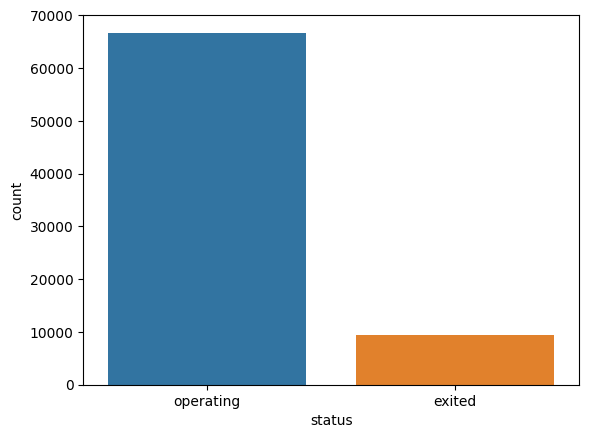

In [ ]:
sns.countplot(x='status', data=df)

We notice that we have a huge class imbalance that we will be dealing with later on

In [ ]:
Q1 = df['total_funding_usd'].quantile(0.25)
Q3 = df['total_funding_usd'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['total_funding_usd'] >= Q1 - 1.5*IQR) & (df['total_funding_usd'] <= Q3 + 1.5*IQR)]

In [ ]:
country = pd.read_csv("/content/drive/My Drive/countryContinent.csv", encoding= 'unicode_escape') # uploading dataset to map countyr code to continent
country = country[['continent', 'code_3', 'country']]
country = country.dropna(how='any',axis=0)
country.isnull().sum() # checking if there is null values

continent    0
code_3       0
country      0
dtype: int64

Perfect! There are no null variables! We can proceed

In [ ]:
df = df.merge(country, left_on='country_code', right_on='code_3')
# merging both datasets and creating new column called continent
df.columns

Index(['uuid', 'country_code', 'region', 'status', 'category_groups_list',
       'num_funding_rounds', 'total_funding_usd', 'founded_on',
       'last_funding_on', 'featured_job_title', 'num_seniors',
       'male_senior_ratio', 'num_degrees', 'seed', 'early_investment',
       'any_investment_funding', 'debt_or_other', 'investor_count',
       'employee_count_cat', 'social_media_presence', 'continent', 'code_3',
       'country'],
      dtype='object')

In [ ]:
df.groupby(by = ['continent'])['uuid'].count().sort_values(ascending=False) #number of companies in each continent
# North America is the highest

continent
North America    25644
Europe           18171
Asia             12559
Americas          4731
Africa            1387
Oceania           1296
Name: uuid, dtype: int64

Notice that we consider North America as only consisting of USA and the rest of that continent is considered as "Americas". This is to make things a bit more balanced.

In [ ]:
df = df.drop(['uuid','country_code','region'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63788 entries, 0 to 63787
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   status                  63788 non-null  object        
 1   category_groups_list    62373 non-null  object        
 2   num_funding_rounds      63788 non-null  float64       
 3   total_funding_usd       63788 non-null  float64       
 4   founded_on              63788 non-null  datetime64[ns]
 5   last_funding_on         63788 non-null  datetime64[ns]
 6   featured_job_title      63788 non-null  object        
 7   num_seniors             63788 non-null  int64         
 8   male_senior_ratio       63788 non-null  float64       
 9   num_degrees             63788 non-null  float64       
 10  seed                    63788 non-null  int64         
 11  early_investment        63788 non-null  int64         
 12  any_investment_funding  63788 non-null  int64 

In [ ]:
df = df.drop(['code_3', 'country'], axis=1)

In [ ]:
# filter the DataFrame to keep only rows where last funding is later than founded date
df = df.loc[df['last_funding_on'] > df['founded_on']]

In [ ]:
import datetime as dt
# calculate the age of the companies from today in years
today = pd.Timestamp(dt.datetime.now())
df.loc[:, 'company_age'] = round((today - df['founded_on']).dt.days / 365, 0)

# calculate the years from now it last received funding
df.loc[:, 'years_since_last_funding'] = round((today - df['last_funding_on']).dt.days / 365, 0)

# calculate the difference in time between last funding on and founded date
df.loc[:, 'years_of_funding_dependence'] = round((df['last_funding_on'] - df['founded_on']).dt.days / 365, 0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61860 entries, 1 to 63787
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   status                       61860 non-null  object        
 1   category_groups_list         60505 non-null  object        
 2   num_funding_rounds           61860 non-null  float64       
 3   total_funding_usd            61860 non-null  float64       
 4   founded_on                   61860 non-null  datetime64[ns]
 5   last_funding_on              61860 non-null  datetime64[ns]
 6   featured_job_title           61860 non-null  object        
 7   num_seniors                  61860 non-null  int64         
 8   male_senior_ratio            61860 non-null  float64       
 9   num_degrees                  61860 non-null  float64       
 10  seed                         61860 non-null  int64         
 11  early_investment             61860 non-nu

In [ ]:
df = df.drop(['founded_on', 'last_funding_on'], axis=1)

In [ ]:
df = df.drop(['featured_job_title'], axis=1)

In [ ]:
df.any_investment_funding.value_counts()

0    45825
1    16035
Name: any_investment_funding, dtype: int64

In [ ]:
# save the DataFrame as a CSV file in Google Drive
df.to_csv('/content/drive/My Drive/startup_data.csv', index=False)